In [1]:
# %% Load Packages and set filepaths

import torch
from byol_pytorch import BYOL
import torch
import torch.nn as nn
import torch.optim as optim

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import HoverTool, ColumnDataSource
import pickle
import torch.nn.functional as F
import umap
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
warnings.filterwarnings("ignore")

# Set parameters
bird_dir = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Canary_Data/llb3/'
audio_files = bird_dir+'llb3_songs'
directory = bird_dir+ 'llb3_data_matrices/Python_Files'
analysis_path = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Analysis/BYOL_Analysis'

# Parameters we set
num_spec = 5
window_size = 100
stride = 10

# Define the folder name
folder_name = f'{analysis_path}/Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}'

# Create the folder if it doesn't already exist
if not os.path.exists(folder_name+"/Plots/Window_Plots"):
    os.makedirs(folder_name+"/Plots/Window_Plots")
    print(f'Folder "{folder_name}" created successfully.')
else:
    print(f'Folder "{folder_name}" already exists.')



if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"  


Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Analysis/BYOL_Analysis/Num_Spectrograms_5_Window_Size_100_Stride_10" created successfully.


In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(90000, 2)

    def forward(self, x):
        x = x.float().to(device)
        x = self.conv(x)
        # x = self.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x.float())
        return x
    
class TweetyNetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5, 5), stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(8, 1), stride=(8, 1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(8, 1), stride=(8, 1))
        self.relu = nn.ReLU()
        self.fc = nn.Linear(150528, 2)

    def forward(self, x):
        x = x.float().to(device)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc(x.float())
        return x

In [3]:
# %% Creating the custom transformation function

class augmentations(nn.Module):
    def __init__(self, stacked_windows_3d, my_dict, window_length, frequency_length, image_size):
        super(augmentations, self).__init__()
        self.stacked_windows_3d = stacked_windows_3d
        self.dict_of_stacked_windows = my_dict
        self.window_length = window_length
        self.frequency_length = frequency_length
        self.image_size = image_size
        self.batch_size = batch_size
    
    
    def augment_fn(self, x):
        
        try: 
            x_smaller = x[:,0,:,:]
            x_smaller = x_smaller.reshape(x_smaller.shape[0], x_smaller.shape[1]*x_smaller.shape[2])
            stacked_windows_smaller = self.stacked_windows_3d
            stacked_windows_smaller = stacked_windows_smaller[:,0,:,:]
            stacked_windows_smaller = stacked_windows_smaller.reshape(stacked_windows_smaller.shape[0], stacked_windows_smaller.shape[1]*stacked_windows_smaller.shape[2])
            res = (stacked_windows_smaller[:, None] == x_smaller).all(-1).any(-1)
            torch_intersecting_rows = torch.nonzero(torch.tensor(res))
            torch_intersecting_rows = torch_intersecting_rows.reshape(torch_intersecting_rows.size(0),).numpy()
            new_tensor = stacked_windows_3d[torch_intersecting_rows+1, :,:,:]
            return new_tensor
        
        except Exception as E:
            dummyDat = torch.randn(x.size(0), 3, self.image_size, self.image_size)
            dummyDat = dummyDat.to(device)
            return dummyDat

    
    def augment_fn2(self, x):
        
        try: 
            x_smaller = x[:,0,:,:]
            x_smaller = x_smaller.reshape(x_smaller.shape[0], x_smaller.shape[1]*x_smaller.shape[2])
            stacked_windows_smaller = self.stacked_windows_3d
            stacked_windows_smaller = stacked_windows_smaller[:,0,:,:]
            stacked_windows_smaller = stacked_windows_smaller.reshape(stacked_windows_smaller.shape[0], stacked_windows_smaller.shape[1]*stacked_windows_smaller.shape[2])
            res = (stacked_windows_smaller[:, None] == x_smaller).all(-1).any(-1)
            torch_intersecting_rows = torch.nonzero(torch.tensor(res))
            torch_intersecting_rows = torch_intersecting_rows.reshape(torch_intersecting_rows.size(0),).numpy()
            new_tensor = stacked_windows_3d[torch_intersecting_rows+2, :,:,:]
            return new_tensor
        
        except Exception as E:
            dummyDat = torch.randn(x.size(0), 3, self.image_size, self.image_size)
            dummyDat = dummyDat.to(device)
            return dummyDat

In [ ]:
# =============================================================================
# # If you are loading the results from a previous analysis, run the following lines of code
# =============================================================================

stacked_windows = np.load(folder_name+'/stacked_windows.npy') # An array of all the mini-spectrograms
labels_for_window = np.load(folder_name+'/labels_for_window.npy') # The syllable labels for each time point in each mini-spectrogram
masked_frequencies = np.load(analysis_path+'/masked_frequencies_lowthresh_500_highthresh_7000.npy') # The frequencies we want to use for analysis. Excluding unnecessarily low and high frequencies
stacked_window_times = np.load(folder_name+'/stacked_window_times.npy') # The onsets and ending of each mini-spectrogram
projection_arr = np.load(folder_name+'/byol_projection.npy')  
embedding_arr = np.load(folder_name+'/byol_embedding.npy')
embedding_after_umap = np.load(folder_name+'/embedding_after_umap.npy')
model = TweetyNetCNN()
model.load_state_dict(torch.load(folder_name+'/trained_cnn.pt'))

# open the file for reading in binary mode
with open(folder_name+'/category_colors.pkl', 'rb') as f:
    # load the dictionary from the file using pickle.load()
    category_colors = pickle.load(f)   
    
# Each syllable is given a unique color. Each mini-spectrogram will have an average syllable color associated with it. This is the average RGB value across all unique syllables in the mini-spectrogram
mean_colors_per_minispec = np.load(folder_name+'/mean_colors_per_minispec.npy')


batch_size = 20
num_batches = int(stacked_windows.shape[0]/batch_size)
height = stacked_window_times.shape[1]
width = int(stacked_windows.shape[1]/height)
image_size = 151

from torch.utils.data import DataLoader

# Define a PyTorch dataset
my_dataloader = DataLoader(stacked_windows, batch_size = batch_size)

# Iterate over the data in batches
batch_sizes_list = []
for batch in my_dataloader:
    # Process the batch of data
    batch_sizes_list.append(batch.shape[0])
    
my_dict = {}
for idx, batch in enumerate(my_dataloader):
    key = idx
    value = batch 
    value = value.reshape(value.shape[0], 1, window_size, width)
    new_size = (image_size, image_size)  # replace with your desired size
    resized_tensor = F.interpolate(value, size=new_size, mode='bilinear', align_corners=False)
    new_tensor = resized_tensor.repeat(1, 3, 1, 1)
    my_dict[idx] = new_tensor

stacked_windows_3d = np.vstack([value for key, value in my_dict.items()])


In [4]:
# =============================================================================
# # If you're running the analysis for the first time 
# =============================================================================

files = os.listdir(directory)
all_songs_data = [element for element in files if '.npz' in element] # Get the file paths of each numpy file from Yarden's data
all_songs_data.sort()
os.chdir(directory)

# For each spectrogram we will extract
# 1. Each timepoint's syllable label
# 2. The spectrogram itself
stacked_labels = [] 
stacked_specs = []
for i in np.arange(num_spec):
    # Extract the data within the numpy file. We will use this to create the spectrogram
    dat = np.load(all_songs_data[i])
    spec = dat['s']
    times = dat['t']
    frequencies = dat['f']
    labels = dat['labels']
    labels = labels.T


    # Let's get rid of higher order frequencies
    mask = (frequencies<7000)&(frequencies>500)
    masked_frequencies = frequencies[mask]

    subsetted_spec = spec[mask.reshape(mask.shape[0],),:]
    
    stacked_labels.append(labels)
    stacked_specs.append(subsetted_spec)

    
stacked_specs = np.concatenate((stacked_specs), axis = 1)
stacked_labels = np.concatenate((stacked_labels), axis = 0)

# Get a list of unique categories (syllable labels)
unique_categories = np.unique(stacked_labels)

# Create a dictionary that maps categories to random colors
category_colors = {category: np.random.rand(3,) for category in unique_categories}

spec_for_analysis = stacked_specs.T
window_labels_arr = []
embedding_arr = []
# Find the exact sampling frequency (the time in miliseconds between one pixel [timepoint] and another pixel)
dx = np.diff(times)[0,0]

# We will now extract each mini-spectrogram from the full spectrogram
stacked_windows = []
# Find the syllable labels for each mini-spectrogram
stacked_labels_for_window = []
# Find the mini-spectrograms onset and ending times 
stacked_window_times = []

# The below for-loop will find each mini-spectrogram (window) and populate the empty lists we defined above.
for i in range(0, spec_for_analysis.shape[0] - window_size + 1, stride):
    # Find the window
    window = spec_for_analysis[i:i + window_size, :]
    # Get the window onset and ending times
    window_times = dx*np.arange(i, i + window_size)
    # We will flatten the window to be a 1D vector
    window = window.reshape(1, window.shape[0]*window.shape[1])
    # Extract the syllable labels for the window
    labels_for_window = stacked_labels[i:i+window_size, :]
    # Reshape the syllable labels for the window into a 1D array
    labels_for_window = labels_for_window.reshape(1, labels_for_window.shape[0]*labels_for_window.shape[1])
    # Populate the empty lists defined above
    stacked_windows.append(window)
    stacked_labels_for_window.append(labels_for_window)
    stacked_window_times.append(window_times)

# Convert the populated lists into a stacked numpy array
stacked_windows = np.stack(stacked_windows, axis = 0)
stacked_windows = np.squeeze(stacked_windows)

stacked_labels_for_window = np.stack(stacked_labels_for_window, axis = 0)
stacked_labels_for_window = np.squeeze(stacked_labels_for_window)

stacked_window_times = np.stack(stacked_window_times, axis = 0)

# For each mini-spectrogram, find the average color across all unique syllables
mean_colors_per_minispec = np.zeros((stacked_labels_for_window.shape[0], 3))
for i in np.arange(stacked_labels_for_window.shape[0]):
    list_of_colors_for_row = [category_colors[x] for x in stacked_labels_for_window[i,:]]
    all_colors_in_minispec = np.array(list_of_colors_for_row)
    mean_color = np.mean(all_colors_in_minispec, axis = 0)
    mean_colors_per_minispec[i,:] = mean_color

# Let's save all the numpy arrays
np.save(folder_name+'/stacked_windows.npy', stacked_windows)
np.save(folder_name+'/labels_for_window.npy', labels_for_window)
np.save(analysis_path+'/masked_frequencies_lowthresh_500_highthresh_7000.npy', masked_frequencies)
np.save(folder_name+'/stacked_window_times.npy', stacked_window_times)
np.save(folder_name+'/mean_colors_per_minispec.npy', mean_colors_per_minispec)

# open a file for writing in binary mode
with open(folder_name+'/category_colors.pkl', 'wb') as f:
    # write the dictionary to the file using pickle.dump()
    pickle.dump(category_colors, f)

# The below function will save an image for each mini-spectrogram. This will be used for understanding the UMAP plot.
def embeddable_image(data, window_times, iteration_number):
    
    data.shape = (window_size, int(data.shape[0]/window_size))
    data = data.T 
    window_times = window_times.reshape(1, window_times.shape[0])
    plt.pcolormesh(window_times, masked_frequencies, data, cmap='jet')
    # let's save the plt colormesh as an image.
    plt.savefig(folder_name+'/Plots/Window_Plots/'+f'Window_{iteration_number}.png')
    plt.close()
    
    
for i in np.arange(stacked_windows.shape[0]):
    if i%10 == 0:
        print(f'Iteration {i} of {stacked_windows.shape[0]}')
    data = stacked_windows[i,:]
    window_times = stacked_window_times[i,:]
    embeddable_image(data, window_times, i)


Iteration 0 of 3323
Iteration 10 of 3323
Iteration 20 of 3323
Iteration 30 of 3323
Iteration 40 of 3323
Iteration 50 of 3323
Iteration 60 of 3323
Iteration 70 of 3323
Iteration 80 of 3323
Iteration 90 of 3323
Iteration 100 of 3323
Iteration 110 of 3323
Iteration 120 of 3323
Iteration 130 of 3323
Iteration 140 of 3323
Iteration 150 of 3323
Iteration 160 of 3323
Iteration 170 of 3323
Iteration 180 of 3323
Iteration 190 of 3323
Iteration 200 of 3323
Iteration 210 of 3323
Iteration 220 of 3323
Iteration 230 of 3323
Iteration 240 of 3323
Iteration 250 of 3323
Iteration 260 of 3323
Iteration 270 of 3323
Iteration 280 of 3323
Iteration 290 of 3323
Iteration 300 of 3323
Iteration 310 of 3323
Iteration 320 of 3323
Iteration 330 of 3323
Iteration 340 of 3323
Iteration 350 of 3323
Iteration 360 of 3323
Iteration 370 of 3323
Iteration 380 of 3323
Iteration 390 of 3323
Iteration 400 of 3323
Iteration 410 of 3323
Iteration 420 of 3323
Iteration 430 of 3323
Iteration 440 of 3323
Iteration 450 of 3323

In [5]:
batch_size = 20
num_batches = int(stacked_windows.shape[0]/batch_size)
height = stacked_window_times.shape[1]
width = int(stacked_windows.shape[1]/height)
image_size = 151

from torch.utils.data import DataLoader

# Define a PyTorch dataset
my_dataloader = DataLoader(stacked_windows, batch_size = batch_size)

# Iterate over the data in batches
batch_sizes_list = []
for batch in my_dataloader:
    # Process the batch of data
    batch_sizes_list.append(batch.shape[0])
    
my_dict = {}
for idx, batch in enumerate(my_dataloader):
    key = idx
    value = batch 
    value = value.reshape(value.shape[0], 1, window_size, width)
    new_size = (image_size, image_size)  # replace with your desired size
    resized_tensor = F.interpolate(value, size=new_size, mode='bilinear', align_corners=False)
    new_tensor = resized_tensor.repeat(1, 3, 1, 1)
    my_dict[idx] = new_tensor

stacked_windows_3d = np.vstack([value for key, value in my_dict.items()])


In [6]:
# In[21]: Initialize the model and the BYOL object 

# model = SimpleCNN()
model = TweetyNetCNN()
model = model.to(device)
augmentations = augmentations(stacked_windows_3d, my_dict, window_size, width, 151 )

augment_fn = augmentations.augment_fn
augment_fn2 = augmentations.augment_fn2
# resnet = resnet.to(device)
learner = BYOL( 
    model,
    image_size = 151,
    projection_size = 2,           # the projection size
    projection_hidden_size = 100,   # the hidden dimension of the MLP for both the projection and prediction
    augment_fn = augment_fn,
    augment_fn2 = augment_fn2
)

learner = learner.to(device)


In [7]:
# %% Run the Model

num_epochs = 100

opt = torch.optim.Adam(learner.parameters(), lr=0.01)
loss_list = []
for i in range(num_epochs):
    batch_loss = []
    
    for b in range(len(my_dict)):
        batch_data = my_dict[b]
    
    # for batch_index, batch_data in enumerate(my_dataloader):
        # print(f'Batch Number: {batch_index}')
        # Extract the batch 
        input_torch_batch = batch_data.to(device)

        # Resize images to be square. Also make the images compatible with BYOL package by adding in 3 channels
        # new_size = (151, 151)  # replace with your desired size
        # resized_tensor = F.interpolate(input_torch_batch, size=new_size, mode='bilinear', align_corners=False)

        # # Print the shape of the resized tensor
        # # print(resized_tensor.shape)

        # # extract the first dimension of the tensor
        # first_dim = resized_tensor.shape[0]

        # # create a new tensor by repeating the original tensor along the new dimensions
        # new_tensor = resized_tensor.repeat(1, 3, 1, 1)
        loss = learner(input_torch_batch, return_embedding = False, return_projection = True)
        batch_loss.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()

    loss_list.append(np.mean(batch_loss))
    if i%1 == 0:
        print(f'Epoch {i}, Mean Batch Loss: {np.mean(batch_loss):.2f}')


torch.save(model.state_dict(), folder_name+'/trained_cnn.pt')


Epoch 0, Mean Batch Loss: 2.33
Epoch 1, Mean Batch Loss: 2.30
Epoch 2, Mean Batch Loss: 2.30
Epoch 3, Mean Batch Loss: 2.33
Epoch 4, Mean Batch Loss: 2.34
Epoch 5, Mean Batch Loss: 2.32
Epoch 6, Mean Batch Loss: 2.31
Epoch 7, Mean Batch Loss: 2.31
Epoch 8, Mean Batch Loss: 2.30
Epoch 9, Mean Batch Loss: 2.33
Epoch 10, Mean Batch Loss: 2.32
Epoch 11, Mean Batch Loss: 2.32
Epoch 12, Mean Batch Loss: 2.31
Epoch 13, Mean Batch Loss: 2.29
Epoch 14, Mean Batch Loss: 2.28
Epoch 15, Mean Batch Loss: 2.31
Epoch 16, Mean Batch Loss: 2.31
Epoch 17, Mean Batch Loss: 2.33
Epoch 18, Mean Batch Loss: 2.30
Epoch 19, Mean Batch Loss: 2.30
Epoch 20, Mean Batch Loss: 2.30
Epoch 21, Mean Batch Loss: 2.35
Epoch 22, Mean Batch Loss: 2.34
Epoch 23, Mean Batch Loss: 2.31
Epoch 24, Mean Batch Loss: 2.31
Epoch 25, Mean Batch Loss: 2.32
Epoch 26, Mean Batch Loss: 2.35
Epoch 27, Mean Batch Loss: 2.31
Epoch 28, Mean Batch Loss: 2.32
Epoch 29, Mean Batch Loss: 2.31
Epoch 30, Mean Batch Loss: 2.32
Epoch 31, Mean Bat

In [8]:
# In[23]: Evaluate the model and extract the projection and embeddings

projection_arr = []
embedding_arr = []
with torch.no_grad():
    for b in range(len(my_dict)):
        batch_data = my_dict[b]
    # for batch_index, batch_data in enumerate(my_dataloader):
        # print(f'Batch Number: {batch_index}')
        # Extract the batch 
        input_torch_batch = batch_data.to(device)
        
        # spec_to_return = input_torch_batch.reshape(input_torch_batch.shape[0], 1, window_size, width)
        
        # new_size = (image_size, image_size)  # replace with your desired size
        # resized_tensor = F.interpolate(spec_to_return, size=new_size, mode='bilinear', align_corners=False)
        
        # # Print the shape of the resized tensor
        # # print(resized_tensor.shape)
        
        # # extract the first dimension of the tensor
        # first_dim = resized_tensor.shape[0]
        
        # # create a new tensor by repeating the original tensor along the new dimensions
        # new_tensor = resized_tensor.repeat(1, 3, 1, 1)
        
        projection, embedding = learner(input_torch_batch, return_embedding = True, return_projection = True)
        projection_arr.append(projection.cpu().detach().numpy())
        embedding_arr.append(embedding.cpu().detach().numpy())


projection_arr = np.concatenate(projection_arr, axis = 0)
embedding_arr = np.concatenate(embedding_arr, axis = 0)
print(projection_arr.shape)
print(embedding_arr.shape)


(3323, 2)
(3323, 150528)


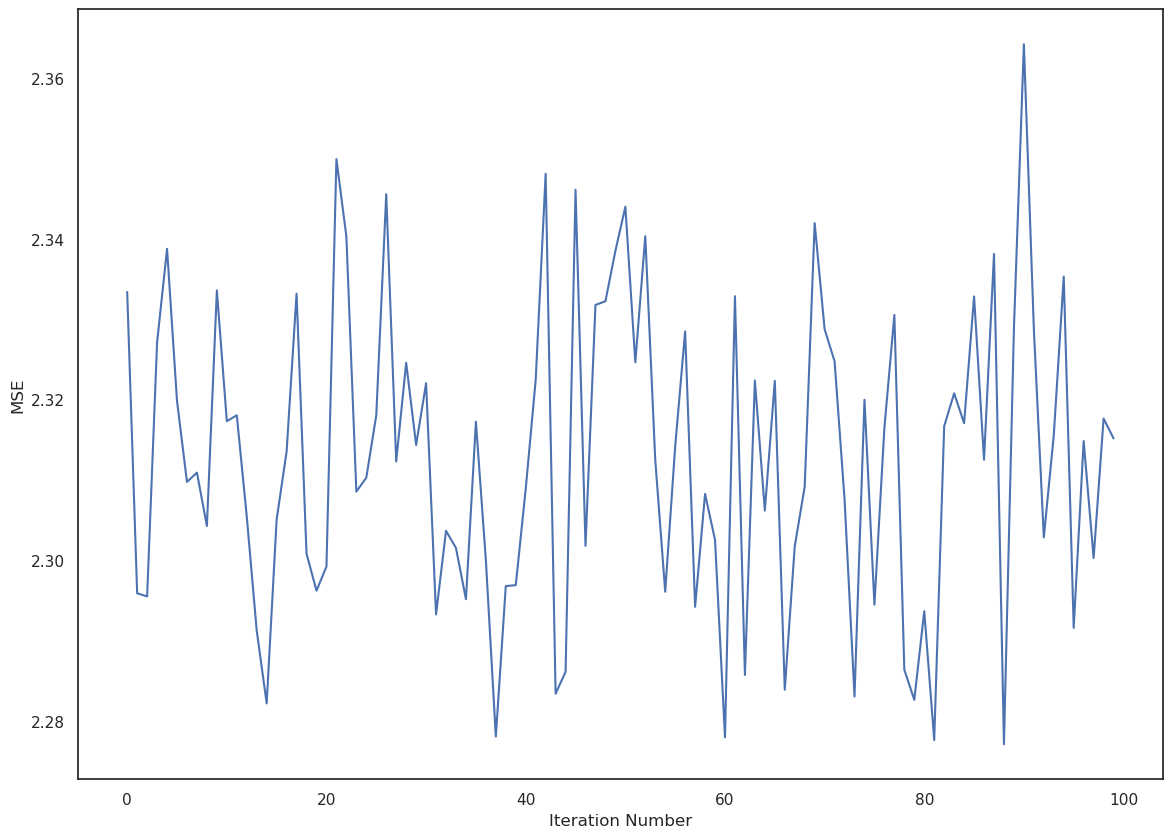

In [9]:
# In[25]: Plot the loss values for training
plt.figure()
plt.plot(loss_list)
plt.xlabel("Iteration Number")
plt.ylabel("MSE")
plt.show()

In [10]:
# %% Perform UMAP on the embedding and plot the embedding

reducer = umap.UMAP()
embedding_after_umap = reducer.fit_transform(embedding_arr)

In [11]:
# In[26]: Plot the BYOL projection. 

# Specify an HTML file to save the Bokeh image to.
output_file(filename=f'{folder_name}/Plots/byol_projection.html')

# projection_arr = projection.clone().detach().numpy()

# Convert the UMAP embedding to a Pandas Dataframe
spec_df = pd.DataFrame(projection_arr, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = projection_arr[:,0], y = projection_arr[:,1], colors=mean_colors_per_minispec))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Set the image path for each data point
source.data['image'] = []
for i in np.arange(spec_df.shape[0]):
    source.data['image'].append(f'{folder_name}/Plots/Window_Plots/Window_{i}.png')

show(p)

save(p)


'/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Analysis/BYOL_Analysis/Num_Spectrograms_5_Window_Size_100_Stride_10/Plots/byol_projection.html'

In [12]:
# Specify an HTML file to save the Bokeh image to.
output_file(filename=f'{folder_name}/Plots/byol_umap_on_embedding.html')


# Convert the UMAP embedding to a Pandas Dataframe
embedding_after_umap_df = pd.DataFrame(embedding_after_umap, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = embedding_after_umap[:,0], y = embedding_after_umap[:,1], colors=mean_colors_per_minispec))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Set the image path for each data point
source.data['image'] = []
for i in np.arange(spec_df.shape[0]):
    source.data['image'].append(f'{folder_name}/Plots/Window_Plots/Window_{i}.png')

show(p)
save(p)

'/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Analysis/BYOL_Analysis/Num_Spectrograms_5_Window_Size_100_Stride_10/Plots/byol_umap_on_embedding.html'

In [ ]:
np.save(folder_name+'/byol_projection.npy', projection_arr)
np.save(folder_name+'/byol_embedding.npy', embedding_arr)
np.save(folder_name+'/embedding_after_umap.npy', embedding_after_umap)
torch.save(model.state_dict(), folder_name+'/trained_cnn.pt')